## Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

## Data Reading

In [6]:
df=pd.read_excel('Adult Census Income_Dataset.xlsx')                                                                                                                

In [7]:
df.to_csv('Adult Income New.csv')

In [8]:
df=pd.read_csv('Adult Income New.csv')

## Data Exploration

In [9]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   fnlwgt          32561 non-null  int64 
 4   education       32561 non-null  object
 5   education.num   32561 non-null  int64 
 6   marital.status  32561 non-null  object
 7   occupation      32561 non-null  object
 8   relationship    32561 non-null  object
 9   race            32561 non-null  object
 10  sex             32561 non-null  object
 11  capital.gain    32561 non-null  int64 
 12  capital.loss    32561 non-null  int64 
 13  hours.per.week  32561 non-null  int64 
 14  native.country  32561 non-null  object
 15  income          32561 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [11]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,32561.0,16280.000000,9399.695394,0.0,8140.0,16280.0,24420.0,32560.0
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [12]:
print('Number of rows:', df.shape[0])

Number of rows: 32561


In [13]:
print('Number of columns:', df.shape[1])

Number of columns: 16


In [14]:
df['income']=df['income'].map({"<=50K":0,">50K":1})

<Axes: xlabel='income', ylabel='count'>

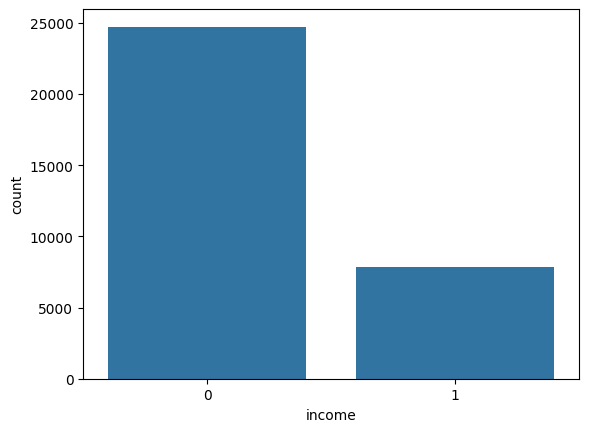

In [15]:
sns.countplot(x='income',data=df)

## Data Pre-Proccessing

### Duplicates

In [16]:
df.duplicated().sum()

0

No duplicate entries.

### Missing Data

In [17]:
columns=df.columns
df[columns]=df.replace('?',np.nan)

In [18]:
100*(df.isnull().sum()/len(df))

Unnamed: 0        0.000000
age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

In [19]:
mode_nativecountry=df['native.country'].mode()[0]

In [20]:
df['workclass']=df['workclass'].fillna('Unemployed')
df['occupation']=df['occupation'].fillna('None')
df['native.country']=df['native.country'].fillna(mode_nativecountry)

In [21]:
df.isnull().sum()

Unnamed: 0        0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [22]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0,90,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0
1,1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0
3,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [23]:
df.corr(numeric_only=True)['income'].sort_values(ascending=False)

income            1.000000
education.num     0.335154
age               0.234037
hours.per.week    0.229689
capital.gain      0.223329
capital.loss      0.150526
fnlwgt           -0.009463
Unnamed: 0       -0.181088
Name: income, dtype: float64

<Axes: >

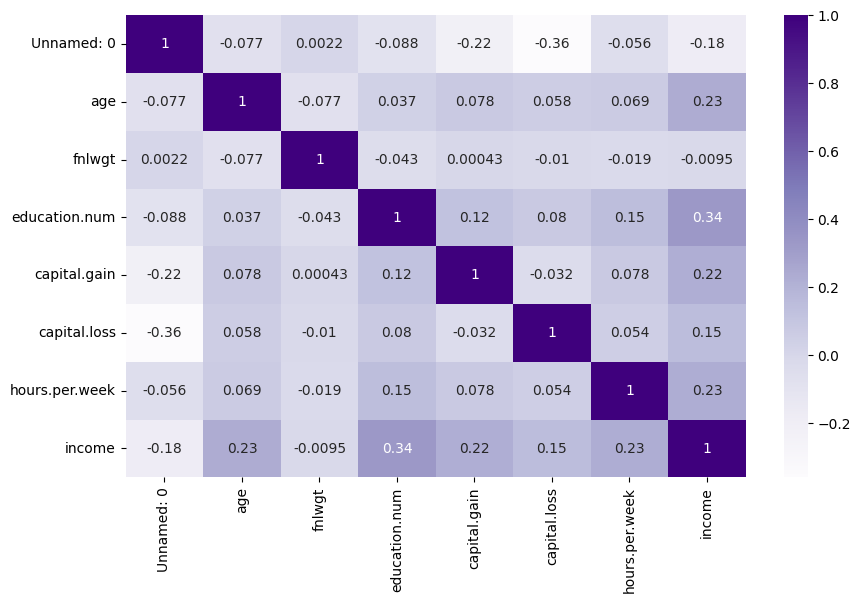

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Purples')

## Feature Expansion

In [25]:
def ageGrouping(column):
    if column<= 30 & column>=17:
        return "Youth"
    elif column <= 50:
        return "Middle-aged"
    else:
        return "Senior"      

In [26]:
df['ageGroup'] = df['age'].apply(ageGrouping)

In [27]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup
0,0,90,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0,Senior
1,1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,Senior
2,2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0,Senior
3,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,Senior
4,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,Middle-aged


### Data Encoding

In [28]:
educationOrder = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Some-college', 'Assoc-voc', 'Assoc-acdm','Bachelors', 'Masters', 'Doctorate','Prof-school']
ageGroupOrder=['Youth','Middle-aged','Senior']

In [29]:
ordinal_encoder = OrdinalEncoder(categories=[educationOrder, ageGroupOrder])
df[['education', 'ageGroup']] = ordinal_encoder.fit_transform(df[['education', 'ageGroup']]).astype(int)

In [30]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup
0,0,90,Unemployed,77053,8,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0,2
1,1,82,Private,132870,8,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,2
2,2,66,Unemployed,186061,9,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0,2
3,3,54,Private,140359,3,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,2
4,4,41,Private,264663,9,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,1


In [31]:
OneHotColumns=['workclass','marital.status','occupation','relationship','race','sex','native.country']

df_encoded = pd.get_dummies(df[OneHotColumns], drop_first=True).astype(int)
df_remaining = df.drop(columns=OneHotColumns)
df = pd.concat([df_remaining, df_encoded], axis=1)

In [32]:
df.columns

Index(['Unnamed: 0', 'age', 'fnlwgt', 'education', 'education.num',
       'capital.gain', 'capital.loss', 'hours.per.week', 'income', 'ageGroup',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Unemployed', 'workclass_Without-pay',
       'marital.status_Married-AF-spouse', 'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent', 'marital.status_Never-married',
       'marital.status_Separated', 'marital.status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_None', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occ

In [34]:
df.corr()['income'].sort_values(ascending=False)

income                               1.000000
marital.status_Married-civ-spouse    0.444696
education                            0.335951
education.num                        0.335154
age                                  0.234037
                                       ...   
occupation_Other-service            -0.156348
Unnamed: 0                          -0.181088
relationship_Not-in-family          -0.188497
relationship_Own-child              -0.228532
marital.status_Never-married        -0.318440
Name: income, Length: 88, dtype: float64

## EDA

In [35]:
df['education'].value_counts()

education
8     10501
9      7291
12     5355
13     1723
10     1382
6      1175
11     1067
5       933
3       646
15      576
4       514
7       433
14      413
2       333
1       168
0        51
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='Density'>

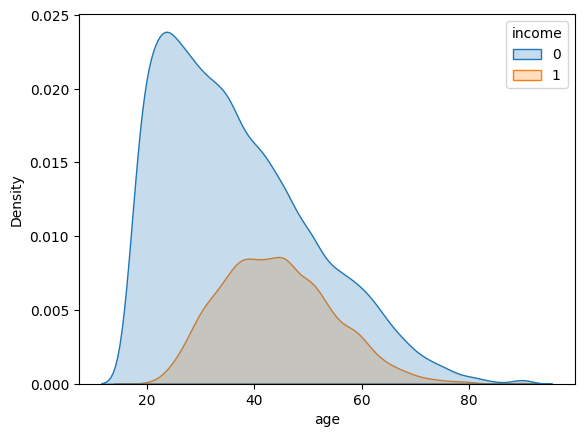

In [41]:
sns.kdeplot(x='age',data=df,hue='income',fill=True)



<Axes: xlabel='education.num', ylabel='count'>

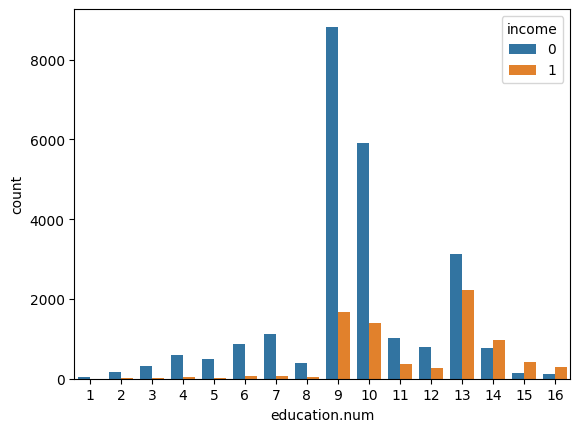

In [42]:
sns.countplot(data=df,x='education.num',hue='income')

<Axes: xlabel='capital.loss', ylabel='age'>

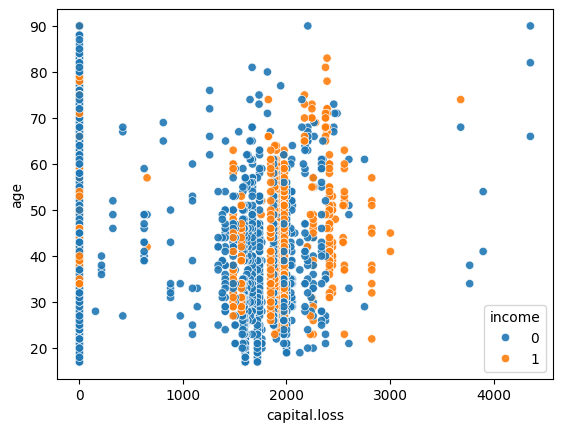

In [ ]:
sns.scatterplot(x='capital.loss',y='age',data=df,hue='income',alpha=0.9)